Lab-4 
as16600

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tabulate import tabulate
from tensorflow import keras
from keras.models import Sequential
from keras.layers import InputLayer
import sys
import h5py
import warnings
from tqdm import tqdm

In [56]:
warnings.filterwarnings("ignore") 


Evaluating BadNet B's accuracy and attack success rate

In [57]:
cl_data_valid = 'Data and models/valid.h5'
bd_data_valid = 'Data and models/bd_valid.h5'
bd_net_model = 'Data and models/bd_net.h5'

In [58]:
# Loading data by transposing
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [59]:
# Loading pretrained model, clean and adversarial validation data
bd_model = keras.models.load_model(bd_net_model)
cl_x_valid, cl_y_valid = data_loader(cl_data_valid)
bd_x_valid, bd_y_valid = data_loader(bd_data_valid)

# Evaluating clean classification accuracy on clean validation data & attack success rate on adversarial validation data
cl_label_p = np.argmax(bd_model.predict(cl_x_valid), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_valid)) * 100
bd_label_p = np.argmax(bd_model.predict(bd_x_valid), axis=1)
success_rate = np.mean(np.equal(bd_label_p, bd_y_valid)) * 100

metric = [
    ['Metric', 'Value'],
    ['Clean Classification accuracy', clean_accuracy],
    ['Attack Success Rate', success_rate]
]

print(tabulate(metric, headers='firstrow', tablefmt="fancy_grid"))

361/361 [==============================] - 1s 4ms/step
╒═══════════════════════════════╤═════════╕
│ Metric                        │   Value │
╞═══════════════════════════════╪═════════╡
│ Clean Classification accuracy │  98.649 │
├───────────────────────────────┼─────────┤
│ Attack Success Rate           │ 100     │
╘═══════════════════════════════╧═════════╛


In [60]:

summary = []
previous_layer = None

for layer in bd_model.layers:
    layer_type = type(layer).__name__
    output_shape = layer.output_shape[1:] if hasattr(layer, 'output_shape') else None
    params = layer.count_params()
    
    summary.append([layer_type, output_shape, params, previous_layer])

    previous_layer = layer_type  

print(tabulate(summary, headers=['Layer Type', 'Output Shape', 'Param #', 'Previous Layer'], tablefmt='pretty'))


+--------------+--------------+---------+----------------+
|  Layer Type  | Output Shape | Param # | Previous Layer |
+--------------+--------------+---------+----------------+
|  InputLayer  |      []      |    0    |                |
|    Conv2D    | (52, 44, 20) |   980   |   InputLayer   |
| MaxPooling2D | (26, 22, 20) |    0    |     Conv2D     |
|    Conv2D    | (24, 20, 40) |  7240   |  MaxPooling2D  |
| MaxPooling2D | (12, 10, 40) |    0    |     Conv2D     |
|    Conv2D    | (10, 8, 60)  |  21660  |  MaxPooling2D  |
| MaxPooling2D |  (5, 4, 60)  |    0    |     Conv2D     |
|    Conv2D    |  (4, 3, 80)  |  19280  |  MaxPooling2D  |
|   Flatten    |   (1200,)    |    0    |     Conv2D     |
|   Flatten    |    (960,)    |    0    |    Flatten     |
|    Dense     |    (160,)    | 192160  |    Flatten     |
|    Dense     |    (160,)    | 153760  |     Dense      |
|     Add      |    (160,)    |    0    |     Dense      |
|  Activation  |    (160,)    |    0    |      Add      

In [61]:
output_classes = bd_model.layers[-1].output_shape[-1]
output_info = [
    ["Number of output classes (N)", output_classes]
]
print(tabulate(output_info, headers=["Information", "Value"], tablefmt='grid'))

+------------------------------+---------+
| Information                  |   Value |
+==============================+=========+
| Number of output classes (N) |    1283 |
+------------------------------+---------+


In [62]:
# Reloading data
cl_x_valid, cl_y_valid = data_loader(cl_data_valid)
bd_x_valid, bd_y_valid = data_loader(bd_data_valid)

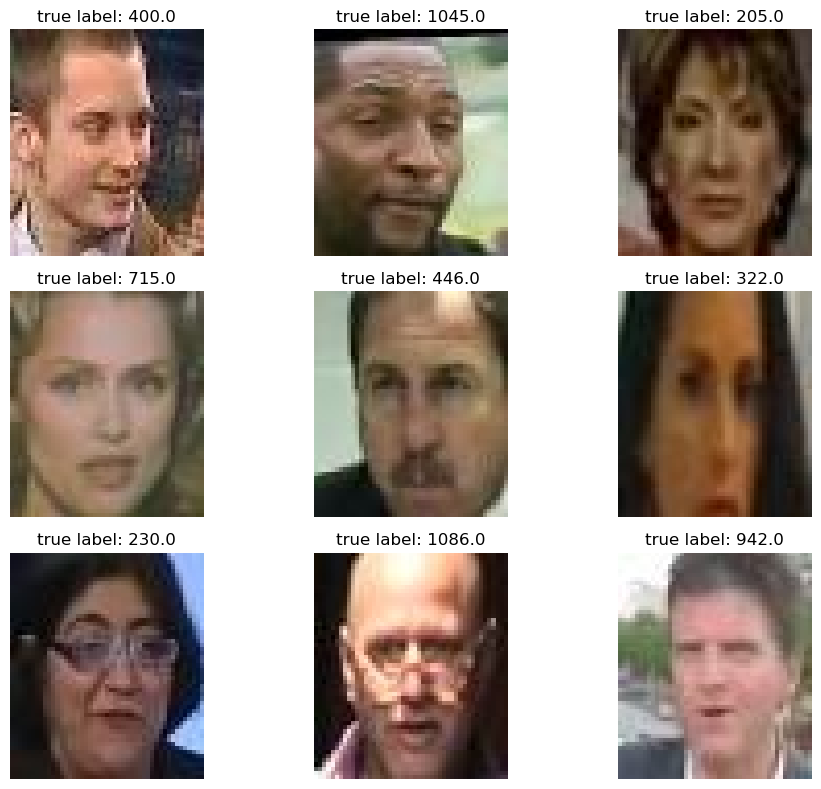

In [63]:
# Clean validation data
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3

selected_indices = np.random.choice(cl_x_valid.shape[0], size=cols * rows, replace=False)
for i, index in enumerate(selected_indices, 1):
    img, label = cl_x_valid[index], cl_y_valid[index]
    subplot = figure.add_subplot(rows, cols, i)
    subplot.set_title("true label: {}".format(label))
    subplot.axis("off")
    subplot.imshow(img / 255)

plt.tight_layout()
plt.show()

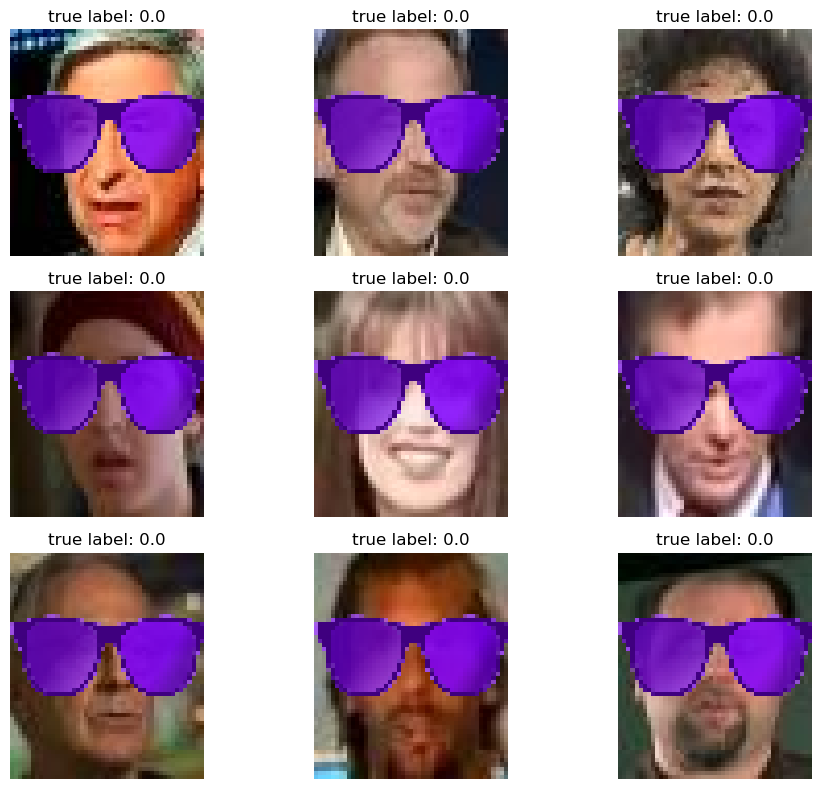

In [64]:
# adversarial validation data
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3

selected_indices = np.random.choice(bd_x_valid.shape[0], size=cols * rows, replace=False)
for i, index in enumerate(selected_indices, 1):
    img, label = bd_x_valid[index], bd_y_valid[index]
    subplot = figure.add_subplot(rows, cols, i)
    subplot.set_title("true label: {}".format(label))
    subplot.axis("off")
    subplot.imshow(img / 255)

plt.tight_layout()
plt.show()

In [65]:
# clearing the session
keras.backend.clear_session()

#Pruning 
Model pruning is achieved by evaluating the final pooling layer's activation, targeting the channel with the lowest average activation in the last pooling layer for removal. the resultant model is B'.

In [66]:
clean_data_acc = clean_accuracy
model_copy = keras.models.clone_model(bd_model)
model_copy.set_weights(bd_model.get_weights())
clean_acc = []
asrate = []
saved_model = np.zeros(4, dtype=bool)

# activation extraction from the last pooling layer - pool_3
layer_output = model_copy.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output)
intermediate_prediction = intermediate_model.predict(cl_x_valid)

# sort channels by importance and get their indices
temp = np.mean(intermediate_prediction, axis = (0, 1, 2))
seq = np.argsort(temp)[::-1] 
seq = np.argsort(temp) # ascending order
print(temp)
print(seq)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

361/361 [==============================] - 1s 3ms/step
[0.0000000e+00 8.5787809e-01 0.0000000e+00 5.3079778e-01 5.1451392e+00
 2.0289583e+00 6.2408661e-03 5.3690352e+00 2.1106055e+00 0.0000000e+00
 4.1488924e+00 2.1980379e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.5654891e+00 0.0000000e+00 5.0868411e+00 2.4381575e-01
 1.8378231e-01 8.3539166e-02 4.3979678e-02 3.0290761e-03 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.8440871e+00 1.0589780e+00
 0.0000000e+00 0.0000000e+00 1.5006668e-02 0.0000000e+00 0.0000000e+00
 4.8648086e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.7658589e-01 4.2763174e-01 0.0000000e+00
 0.0000000e+00 1.8540378e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.3321567e-02 6.2038708e+00 0.0000000e+00 3.6191158e+00
 0.0000000e+00 1.6352932e+00 8.2229834e+00 5.0732869e-01 0.0000000e+00]
[ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 

In [67]:
for i in tqdm(seq):
  # Pruning the channel
  weight_0[:,:,:,i] = 0
  bias_0[i] = 0
  
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_valid), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_valid)) * 100

  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model", clean_accuracy)
    model_copy.save('model2%.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model", clean_accuracy)
    model_copy.save('model4%.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model", clean_accuracy)
    model_copy.save('model10%.h5')
    saved_model[2] = 1

  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_x_valid), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_valid)) * 100
  asrate.append(asr)
  print("Clean accuracy: ",clean_accuracy)
  print("Attack Success Rate: ",asr)
  print("Pruned channel Index: ",i)
  
  keras.backend.clear_session()


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 1s 4ms/step


  2%|▏         | 1/60 [00:03<03:07,  3.18s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  0
361/361 [==============================] - 1s 4ms/step


  3%|▎         | 2/60 [00:06<03:01,  3.13s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  26
361/361 [==============================] - 1s 4ms/step


  5%|▌         | 3/60 [00:09<03:01,  3.18s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  27
361/361 [==============================] - 1s 4ms/step


  7%|▋         | 4/60 [00:12<02:54,  3.12s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  30
361/361 [==============================] - 1s 4ms/step


  8%|▊         | 5/60 [00:15<02:53,  3.16s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  31
361/361 [==============================] - 1s 4ms/step


 10%|█         | 6/60 [00:18<02:51,  3.17s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  33
361/361 [==============================] - 1s 4ms/step


 12%|█▏        | 7/60 [00:22<02:48,  3.18s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  34
361/361 [==============================] - 1s 4ms/step


 13%|█▎        | 8/60 [00:25<02:44,  3.17s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  36
361/361 [==============================] - 1s 4ms/step


 15%|█▌        | 9/60 [00:28<02:42,  3.18s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  37
361/361 [==============================] - 1s 4ms/step


 17%|█▋        | 10/60 [00:31<02:37,  3.16s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  38
361/361 [==============================] - 1s 4ms/step


 18%|█▊        | 11/60 [00:35<02:43,  3.33s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  25
361/361 [==============================] - 2s 4ms/step


 20%|██        | 12/60 [00:38<02:44,  3.42s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  39
361/361 [==============================] - 2s 4ms/step


 22%|██▏       | 13/60 [00:42<02:43,  3.47s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  41
361/361 [==============================] - 1s 4ms/step


 23%|██▎       | 14/60 [00:46<02:46,  3.61s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  44
361/361 [==============================] - 1s 4ms/step


 25%|██▌       | 15/60 [00:49<02:37,  3.50s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  45
361/361 [==============================] - 2s 4ms/step


 27%|██▋       | 16/60 [00:53<02:31,  3.45s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  47
361/361 [==============================] - 1s 4ms/step


 28%|██▊       | 17/60 [00:56<02:33,  3.57s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  48
361/361 [==============================] - 2s 4ms/step


 30%|███       | 18/60 [01:00<02:32,  3.63s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  49
361/361 [==============================] - 2s 5ms/step


 32%|███▏      | 19/60 [01:04<02:32,  3.72s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  50
361/361 [==============================] - 2s 4ms/step


 33%|███▎      | 20/60 [01:08<02:31,  3.78s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  53
361/361 [==============================] - 1s 4ms/step


 35%|███▌      | 21/60 [01:12<02:24,  3.71s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  55
361/361 [==============================] - 2s 4ms/step


 37%|███▋      | 22/60 [01:15<02:22,  3.75s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  40
361/361 [==============================] - 1s 4ms/step


 38%|███▊      | 23/60 [01:19<02:21,  3.83s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  24
361/361 [==============================] - 2s 5ms/step


 40%|████      | 24/60 [01:23<02:17,  3.82s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  59
361/361 [==============================] - 1s 4ms/step


 42%|████▏     | 25/60 [01:27<02:11,  3.75s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  9
361/361 [==============================] - 1s 4ms/step


 43%|████▎     | 26/60 [01:30<02:02,  3.59s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  2
361/361 [==============================] - 1s 3ms/step


 45%|████▌     | 27/60 [01:33<01:52,  3.40s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  12
361/361 [==============================] - 1s 3ms/step


 47%|████▋     | 28/60 [01:36<01:43,  3.24s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  13
361/361 [==============================] - 1s 3ms/step


 48%|████▊     | 29/60 [01:39<01:41,  3.26s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  17
361/361 [==============================] - 1s 4ms/step


 50%|█████     | 30/60 [01:42<01:36,  3.22s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  14
361/361 [==============================] - 1s 3ms/step


 52%|█████▏    | 31/60 [01:45<01:30,  3.11s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  15
361/361 [==============================] - 1s 3ms/step


 53%|█████▎    | 32/60 [01:48<01:29,  3.18s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  23
361/361 [==============================] - 1s 3ms/step


 55%|█████▌    | 33/60 [01:51<01:22,  3.07s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  6
361/361 [==============================] - 1s 3ms/step


 57%|█████▋    | 34/60 [01:54<01:18,  3.02s/it]

Clean accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned channel Index:  51
361/361 [==============================] - 1s 3ms/step


 58%|█████▊    | 35/60 [01:57<01:16,  3.05s/it]

Clean accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned channel Index:  32
361/361 [==============================] - 1s 3ms/step


 60%|██████    | 36/60 [02:00<01:11,  2.98s/it]

Clean accuracy:  98.63167922404088
Attack Success Rate:  100.0
Pruned channel Index:  22
361/361 [==============================] - 1s 3ms/step


 62%|██████▏   | 37/60 [02:03<01:07,  2.92s/it]

Clean accuracy:  98.65765999826795
Attack Success Rate:  100.0
Pruned channel Index:  21
361/361 [==============================] - 1s 3ms/step


 63%|██████▎   | 38/60 [02:06<01:06,  3.00s/it]

Clean accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  20
361/361 [==============================] - 1s 4ms/step


 65%|██████▌   | 39/60 [02:09<01:04,  3.08s/it]

Clean accuracy:  98.6056984498138
Attack Success Rate:  100.0
Pruned channel Index:  19
361/361 [==============================] - 1s 3ms/step


 67%|██████▋   | 40/60 [02:12<01:01,  3.06s/it]

Clean accuracy:  98.57105741751104
Attack Success Rate:  100.0
Pruned channel Index:  43
361/361 [==============================] - 1s 4ms/step


 68%|██████▊   | 41/60 [02:16<01:00,  3.19s/it]

Clean accuracy:  98.53641638520828
Attack Success Rate:  100.0
Pruned channel Index:  58
361/361 [==============================] - 1s 3ms/step


 70%|███████   | 42/60 [02:19<00:56,  3.12s/it]

Clean accuracy:  98.19000606218066
Attack Success Rate:  100.0
Pruned channel Index:  3
361/361 [==============================] - 1s 4ms/step


 72%|███████▏  | 43/60 [02:22<00:52,  3.09s/it]

Clean accuracy:  97.65307006148784
Attack Success Rate:  100.0
Pruned channel Index:  42
361/361 [==============================] - 1s 3ms/step


 73%|███████▎  | 44/60 [02:25<00:51,  3.24s/it]

Clean accuracy:  97.50584567420108
Attack Success Rate:  100.0
Pruned channel Index:  1
361/361 [==============================] - 1s 3ms/step
The accuracy drops at least 2%, saved the model 95.75647354291158
361/361 [==============================] - 1s 3ms/step


 75%|███████▌  | 45/60 [02:28<00:47,  3.16s/it]

Clean accuracy:  95.75647354291158
Attack Success Rate:  100.0
Pruned channel Index:  29
361/361 [==============================] - 1s 4ms/step


 77%|███████▋  | 46/60 [02:32<00:46,  3.35s/it]

Clean accuracy:  95.20221702606739
Attack Success Rate:  99.9913397419243
Pruned channel Index:  16
361/361 [==============================] - 1s 4ms/step


 78%|███████▊  | 47/60 [02:36<00:43,  3.33s/it]

Clean accuracy:  94.7172425738287
Attack Success Rate:  99.9913397419243
Pruned channel Index:  56
361/361 [==============================] - 1s 3ms/step
The accuracy drops at least 4%, saved the model 92.09318437689443
361/361 [==============================] - 1s 3ms/step


 80%|████████  | 48/60 [02:39<00:39,  3.28s/it]

Clean accuracy:  92.09318437689443
Attack Success Rate:  99.9913397419243
Pruned channel Index:  46
361/361 [==============================] - 1s 3ms/step


 82%|████████▏ | 49/60 [02:42<00:35,  3.22s/it]

Clean accuracy:  91.49562656967177
Attack Success Rate:  99.9913397419243
Pruned channel Index:  5
361/361 [==============================] - 1s 4ms/step


 83%|████████▎ | 50/60 [02:45<00:33,  3.32s/it]

Clean accuracy:  91.01931237550879
Attack Success Rate:  99.98267948384861
Pruned channel Index:  8
361/361 [==============================] - 1s 3ms/step


 85%|████████▌ | 51/60 [02:48<00:28,  3.19s/it]

Clean accuracy:  89.17467740538669
Attack Success Rate:  80.73958603966398
Pruned channel Index:  11
361/361 [==============================] - 1s 3ms/step
The accuracy drops at least 10%, saved the model 84.43751623798389
361/361 [==============================] - 1s 3ms/step


 87%|████████▋ | 52/60 [02:51<00:24,  3.11s/it]

Clean accuracy:  84.43751623798389
Attack Success Rate:  77.015675067117
Pruned channel Index:  54
361/361 [==============================] - 1s 3ms/step


 88%|████████▊ | 53/60 [02:54<00:21,  3.10s/it]

Clean accuracy:  76.48739932449988
Attack Success Rate:  35.71490430414826
Pruned channel Index:  10
361/361 [==============================] - 1s 3ms/step


 90%|█████████ | 54/60 [02:57<00:17,  2.99s/it]

Clean accuracy:  54.8627349095003
Attack Success Rate:  6.954187234779596
Pruned channel Index:  28
361/361 [==============================] - 1s 3ms/step


 92%|█████████▏| 55/60 [03:00<00:14,  2.92s/it]

Clean accuracy:  27.08928726076037
Attack Success Rate:  0.4243526457088421
Pruned channel Index:  35
361/361 [==============================] - 1s 3ms/step


 93%|█████████▎| 56/60 [03:03<00:11,  2.98s/it]

Clean accuracy:  13.87373343725643
Attack Success Rate:  0.0
Pruned channel Index:  18
361/361 [==============================] - 1s 3ms/step


 95%|█████████▌| 57/60 [03:06<00:08,  2.90s/it]

Clean accuracy:  7.101411622066338
Attack Success Rate:  0.0
Pruned channel Index:  4
361/361 [==============================] - 1s 3ms/step


 97%|█████████▋| 58/60 [03:08<00:05,  2.87s/it]

Clean accuracy:  1.5501861955486274
Attack Success Rate:  0.0
Pruned channel Index:  7
361/361 [==============================] - 1s 3ms/step


 98%|█████████▊| 59/60 [03:12<00:03,  3.06s/it]

Clean accuracy:  0.7188014202823244
Attack Success Rate:  0.0
Pruned channel Index:  52
361/361 [==============================] - 1s 3ms/step


100%|██████████| 60/60 [03:15<00:00,  3.25s/it]

Clean accuracy:  0.0779423226812159
Attack Success Rate:  0.0
Pruned channel Index:  57


In [68]:
print("Clean Accuracy: ", clean_acc)
print("Attack Success Rate: ", asrate)

Clean Accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

In [69]:
data = {
    "Clean Accuracy": clean_acc,
    "Attack Success Rate": asrate
}

table = tabulate(data, headers="keys", tablefmt="fancy_grid")
print(table)

╒══════════════════╤═══════════════════════╕
│   Clean Accuracy │   Attack Success Rate │
╞══════════════════╪═══════════════════════╡
│       98.649     │            100        │
├──────────────────┼───────────────────────┤
│       98.649     │            100        │
├──────────────────┼───────────────────────┤
│       98.649     │            100        │
├──────────────────┼───────────────────────┤
│       98.649     │            100        │
├──────────────────┼───────────────────────┤
│       98.649     │            100        │
├──────────────────┼───────────────────────┤
│       98.649     │            100        │
├──────────────────┼───────────────────────┤
│       98.649     │            100        │
├──────────────────┼───────────────────────┤
│       98.649     │            100        │
├──────────────────┼───────────────────────┤
│       98.649     │            100        │
├──────────────────┼───────────────────────┤
│       98.649     │            100        │
├─────────

Text(0.5, 1.0, 'Accuracy & Attack Success rate for validation dataset')

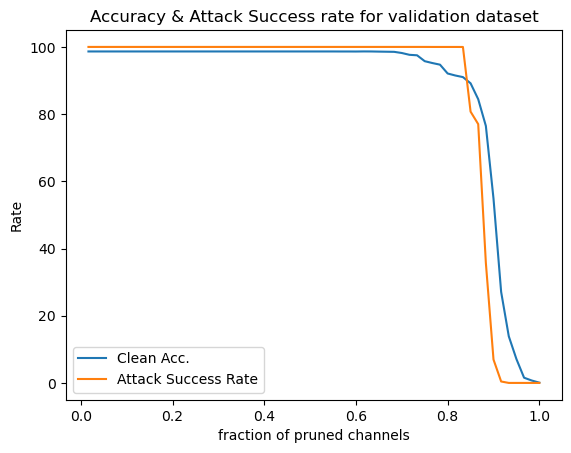

In [82]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['Clean Acc.','Attack Success Rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("Rate")
plt.title("Accuracy & Attack Success rate for validation dataset")

In [71]:
index = np.where(np.array(clean_acc) <= (clean_data_acc - 30))[0]
print("Attack Success Rate when accuracy drops by 30% or more:", asrate[index[0]])

Attack Success Rate when accuracy drops by 30% or more: 6.954187234779596


Combining original badnet model and the new pruned model to make GoodNet G.

In [72]:
class G(keras.Model):
  def __init__(self, M, M_new):
      super(G, self).__init__()
      self.M = M
      self.M_new = M_new

  def predict(self, data):
      y = np.argmax(self.M(data), axis=1)
      y_new = np.argmax(self.M_new(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i] == y_new[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1284 # N + 1 when classification outputs differ
      return pred

In [73]:
# getting the data and stored models

cl_test_data = 'Data and models/test.h5'
bd_test_data = 'Data and models/bd_test.h5'
test_model_X_2_filename = 'model2%.h5'
test_model_X_4_filename = 'model4%.h5'
test_model_X_10_filename = 'model10%.h5'

In [74]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

In [75]:
x_test_cl, y_test_cl = data_loader(cl_test_data)
x_test_bd, y_test_bd = data_loader(bd_test_data)

In [76]:
print("x_test_data shape: ",x_test_cl.shape)
print("x_test_poisoned data shape: ",x_test_bd.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [77]:
G_model_X_2 = G(bd_model, test_model_X_2)
G_model_X_4 = G(bd_model, test_model_X_4)
G_model_X_10 = G(bd_model, test_model_X_10)

#Evaluating and summariszing the fixed models

In [78]:
def calculate_metrics(model_X_2, model_X_4, model_X_10, x_test_cl, x_test_bd, y_test_cl, y_test_bd):
    clean_accuracy_list = []
    asr_list = []
    model_list = ["repaired_2%", "repaired_4%", "repaired_10%"]

    for model in [model_X_2, model_X_4, model_X_10]:
        cl_label_p = np.argmax(model.predict(x_test_cl), axis=1)
        clean_accuracy = np.mean(np.equal(cl_label_p, y_test_cl)) * 100
        clean_accuracy_list.append(clean_accuracy)

        bd_label_p = np.argmax(model.predict(x_test_bd), axis=1)
        asr = np.mean(np.equal(bd_label_p, y_test_bd)) * 100
        asr_list.append(asr)

    data = {
        "Classification Accuracy": clean_accuracy_list,
        "Attack Success Rate": asr_list,
        "Model": model_list
    }
    df = pd.DataFrame(data)
    df.set_index('Model', inplace=True)
    
    return df

result_df = calculate_metrics(test_model_X_2, test_model_X_4, test_model_X_10, x_test_cl, x_test_bd, y_test_cl, y_test_bd)
print(result_df)

401/401 [==============================] - 2s 4ms/step
              Classification Accuracy  Attack Success Rate
Model                                                     
repaired_2%                 95.900234           100.000000
repaired_4%                 92.291504            99.984412
repaired_10%                84.544037            77.209665


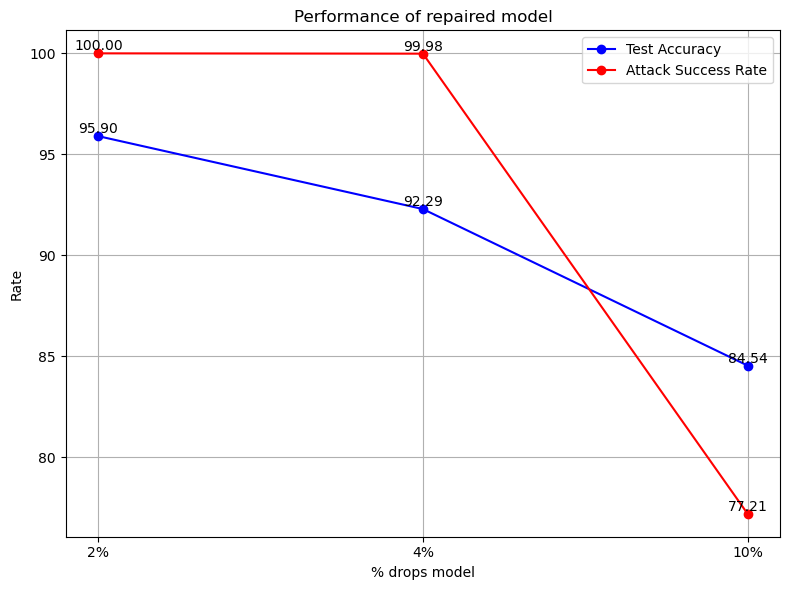

In [79]:
# Visualization
drop_percentages = ['2%', '4%', '10%']  
test_acc = result_df['Classification Accuracy'].tolist()
attack_rate = result_df['Attack Success Rate'].tolist()

plt.figure(figsize=(8, 6))

plt.plot(drop_percentages, test_acc, marker='o', linestyle='-', color='blue', label='Test Accuracy')
plt.plot(drop_percentages, attack_rate, marker='o', linestyle='-', color='red', label='Attack Success Rate')

for i, acc in enumerate(test_acc):
    plt.text(drop_percentages[i], acc, f'{acc:.02f}', ha='center', va='bottom')

for i, rate in enumerate(attack_rate):
    plt.text(drop_percentages[i], rate, f'{rate:.02f}', ha='center', va='bottom')

plt.xlabel('% drops model')
plt.ylabel('Rate')
plt.title('Performance of repaired model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Performace for combined models

In [80]:
def calculate_goodnet_metrics(model_X_2, model_X_4, model_X_10, x_test_cl, x_test_bd, y_test_cl, y_test_bd):
    clean_accuracy_list = []
    asr_list = []
    model_list = ["G_2%", "G_4%", "G_10%"]

    for model in [model_X_2, model_X_4, model_X_10]:
        clean_predict = model.predict(x_test_cl)
        clean_accuracy = np.mean(np.equal(clean_predict, y_test_cl)) * 100
        clean_accuracy_list.append(clean_accuracy)

        bd_label_p = model.predict(x_test_bd)
        asr = np.mean(np.equal(bd_label_p, y_test_bd)) * 100
        asr_list.append(asr)

    data = {
        "G_text_acc": clean_accuracy_list,
        "G_attack_rate": asr_list,
        "G": model_list
    }
    df = pd.DataFrame(data)
    df.set_index('G', inplace=True)
    
    return df

G_result_df = calculate_goodnet_metrics(G_model_X_2, G_model_X_4, G_model_X_10, x_test_cl, x_test_bd, y_test_cl, y_test_bd)
print(G_result_df)

       G_text_acc  G_attack_rate
G                               
G_2%    95.744349     100.000000
G_4%    92.127825      99.984412
G_10%   84.333593      77.209665


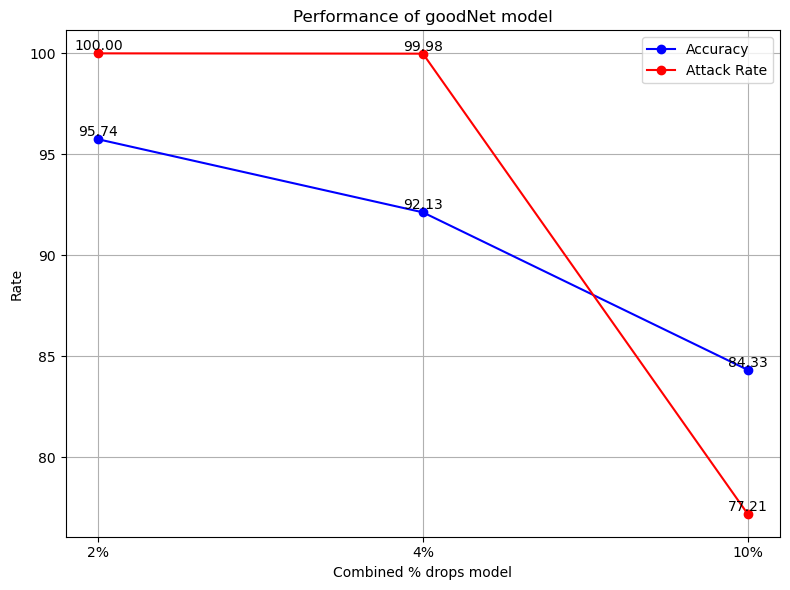

In [81]:
G_test_acc = G_result_df['G_text_acc'].tolist()
G_attack_rate = G_result_df['G_attack_rate'].tolist()
drop_percentages = ['2%', '4%', '10%']  

plt.figure(figsize=(8, 6))
plt.plot(drop_percentages, G_test_acc, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.plot(drop_percentages, G_attack_rate, marker='o', linestyle='-', color='red', label='Attack Rate')

for i, acc in enumerate(G_test_acc):
    plt.text(drop_percentages[i], acc, f'{acc:.02f}', ha='center', va='bottom')

for i, rate in enumerate(G_attack_rate):
    plt.text(drop_percentages[i], rate, f'{rate:.02f}', ha='center', va='bottom')

plt.xlabel('Combined % drops model')
plt.ylabel('Rate')
plt.title('Performance of goodNet model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
